
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       0.00      0.00      0.00         2

    accuracy                           0.99       429
   macro avg       0.50      0.50      0.50       429
weighted avg       0.99      0.99      0.99       429



C:\Users\user\AppData\Local\Temp\ipykernel_45456\1613984656.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diabetes'] = (df['Diabetes_Diagnosis'] == 1).astype(int)


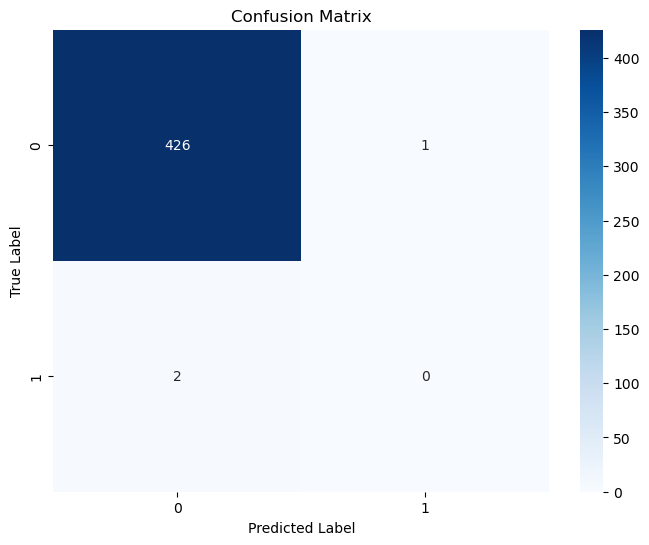

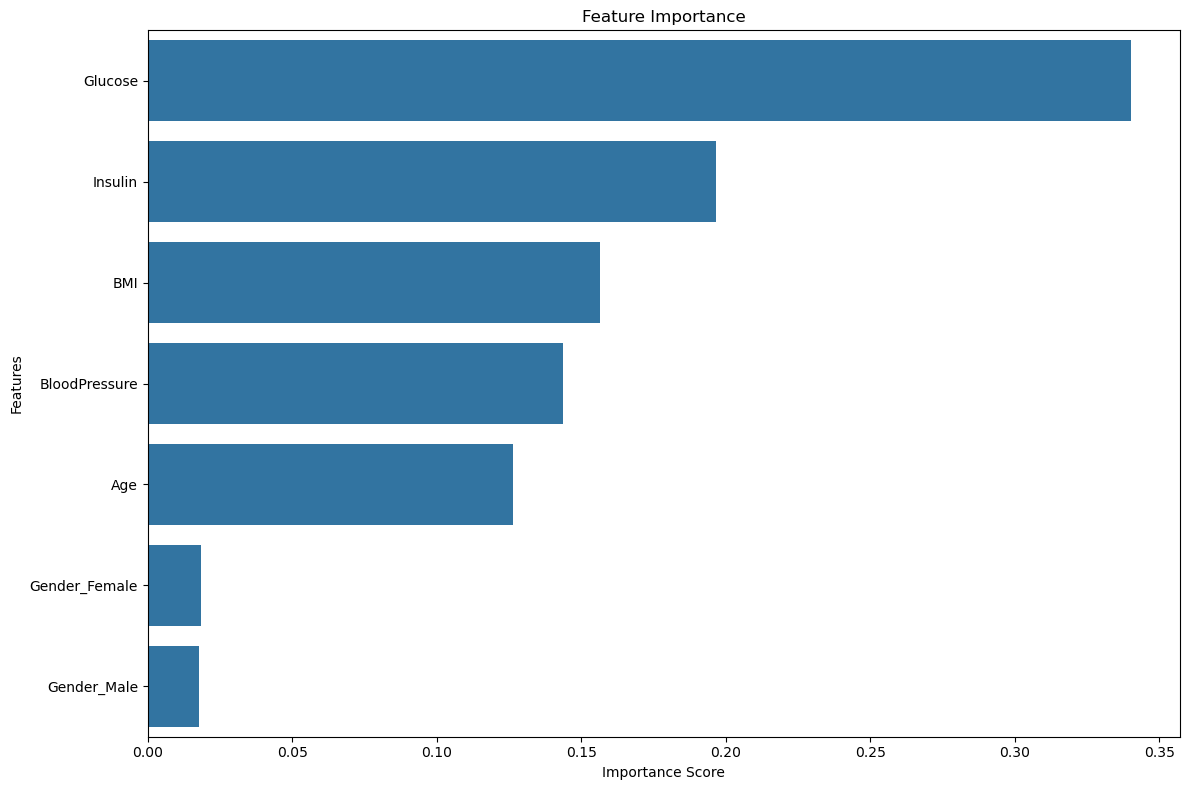


Feature names for making predictions:
['Age', 'BMI', 'BloodPressure', 'Glucose', 'Insulin', 'Gender_Female', 'Gender_Male']


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
demographic = pd.read_csv('Dataset/demographic.csv')
examination = pd.read_csv('Dataset/examination.csv')
labs = pd.read_csv('Dataset/labs.csv')
questionnaire = pd.read_csv('Dataset/questionnaire.csv')

# Select relevant features from each dataset
# Demographic features
demo_features = demographic[['SEQN', 'RIAGENDR', 'RIDAGEYR']]
# Rename demographic columns
demo_features.columns = ['ID', 'Gender', 'Age']

# Examination features
exam_features = examination[['SEQN', 'BMXBMI', 'BPXDI1']]
# Rename examination columns
exam_features.columns = ['ID', 'BMI', 'BloodPressure'] # Diastolic = 張開 ; Systolic_BP = 收縮 ; Diastolic_BP = BloodPressure In Pima

# Lab features
lab_features = labs[['SEQN', 'LBXGLT', 'LBXIN']]  # LBXIN = Insulin (uU/mL) (no specify 2Hour)
# Rename lab columns
lab_features.columns = ['ID', 'Glucose', 'Insulin']

# Questionnaire features
quest_features = questionnaire[['SEQN', 'DIQ010']]
quest_features.columns = ['ID', 'Diabetes_Diagnosis']

# Merge all datasets
merged_data = demo_features.merge(exam_features, on='ID', how='left')\
    .merge(lab_features, on='ID', how='left')\
    .merge(quest_features, on='ID', how='left')

# Create category mappings
gender_map = {1: 'Male', 2: 'Female'}


# Apply mappings
merged_data['Gender'] = merged_data['Gender'].map(gender_map)


# Convert categorical variables to dummy variables
merged_data = pd.get_dummies(merged_data, columns=['Gender'])

# Clean and preprocess data
def preprocess_data(df):
    # Handle missing values
    df = df.dropna()
    
    # Create target variable (1 for diabetes, 0 for no diabetes)
    df['diabetes'] = (df['Diabetes_Diagnosis'] == 1).astype(int)
    
    # Drop unnecessary columns
    df = df.drop(['ID', 'Diabetes_Diagnosis'], axis=1)
    
    return df

# Preprocess the merged dataset
processed_data = preprocess_data(merged_data)

# Split features and target
X = processed_data.drop('diabetes', axis=1)
y = processed_data['diabetes']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print model evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Function to predict diabetes risk for new patients
def predict_diabetes_risk(patient_data):
    # Scale the input data
    scaled_data = scaler.transform(patient_data)
    # Get prediction probability
    risk_prob = rf_model.predict_proba(scaled_data)[:, 1]
    return risk_prob

# Print the feature names for reference when making predictions
print("\nFeature names for making predictions:")
print(X.columns.tolist())

In [5]:
processed_data

,Age,BMI,BloodPressure,Glucose,Insulin,Gender_Female,Gender_Male,diabetes
7,61,35.7,80.0,150.0,14.91,True,False,0
11,26,20.3,60.0,80.0,3.85,True,False,0
19,16,23.2,68.0,68.0,6.14,False,True,0
20,32,28.9,74.0,84.0,16.15,False,True,0
23,38,35.9,84.0,81.0,10.92,True,False,0
...,...,...,...,...,...,...,...,...
10154,38,33.5,76.0,73.0,6.53,True,False,0
10155,61,30.0,70.0,208.0,13.02,False,True,0
10156,34,23.7,66.0,124.0,21.41,False,True,0
10161,60,27.4,72.0,108.0,4.99,True,False,0


In [15]:
stat_df = processed_data.describe().style 
stat_df

,Age,BMI,BloodPressure,Glucose,Insulin,diabetes
count,2142.000000,2142.000000,2142.000000,2142.000000,2142.000000,2142.000000
mean,41.386088,27.805836,66.695612,114.444911,11.748002,0.008870
std,20.089521,7.159867,13.109526,46.908863,9.579569,0.093785
min,12.000000,14.500000,0.000000,40.000000,0.140000,0.000000
25%,23.000000,22.800000,58.500000,86.000000,5.790000,0.000000
50%,40.000000,26.700000,68.000000,104.000000,8.990000,0.000000
75%,57.000000,31.100000,74.000000,130.000000,14.375000,0.000000
max,80.000000,70.100000,122.000000,604.000000,102.290000,1.000000
